In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot
from simulations.analysis.plotting_helpers import load_data

In [14]:
df_ps_dict = load_data(["color"])

## pfail vs pabort

logical error rate vs spacetime cost (code distance & abort rate) at a physical error rate
or vs footprint (space cost)

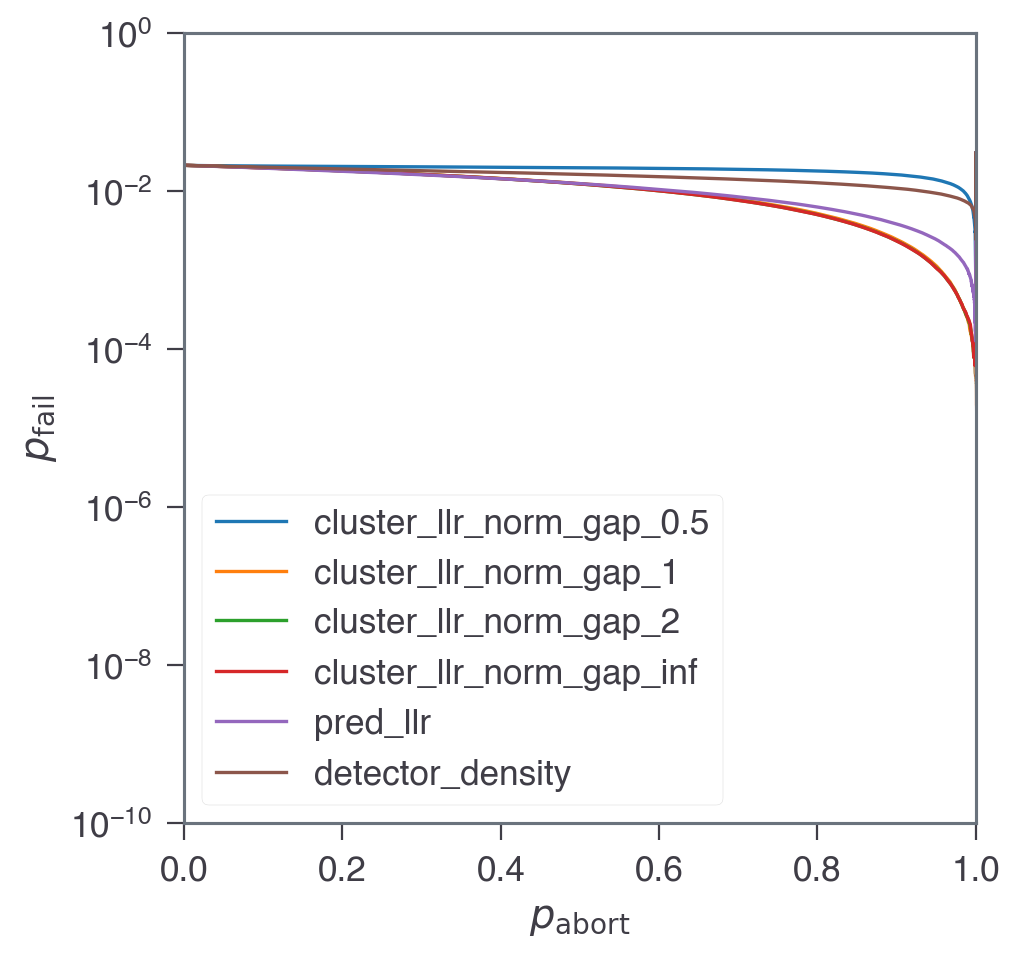

In [ ]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

d = T = 9
p = 5e-3

# Create ordered list of keys
ordered_keys = []

# First, add cluster_llr_norm_gap keys in ascending order of i (as float)
cluster_keys = [key for key in df_ps_dict.keys() if "cluster_llr_norm_gap" in key]
# Sort by extracting the number after 'cluster_llr_norm_gap_' as float
cluster_keys.sort(
    key=lambda x: (
        float(x.split("_")[-1])
        if x.split("_")[-1].replace(".", "").isdigit()
        else float("inf")
    )
)
ordered_keys.extend(cluster_keys)

# Then add the other keys in specified order
for key in ["matching_gap", "pred_llr", "detector_density"]:
    if key in df_ps_dict:
        ordered_keys.append(key)

i = 0
data_plots = {}
for by in ordered_keys:
    df_ps_all = df_ps_dict[by]
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps_all.loc[idx[d, T, p, :], :]

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

relation to BP convergence

0: cluster_llr_norm_gap_2 (9.15e-07 ± 2.19e-07)
1: cluster_llr_norm_gap_1 (9.15e-07 ± 2.19e-07)
2: cluster_llr_norm_1 (9.15e-07 ± 2.19e-07)
3: cluster_llr_norm_gap_inf (9.56e-07 ± 2.24e-07)
4: cluster_llr_norm_2 (1.03e-06 ± 2.32e-07)
5: cluster_llr_norm_inf (1.19e-06 ± 2.50e-07)
6: cluster_llr_norm_gap_0.5 (2.29e-06 ± 3.49e-07)
7: cluster_llr_norm_0.5 (4.51e-06 ± 4.90e-07)
8: pred_llr (7.40e-06 ± 6.28e-07)
9: detector_density (8.84e-05 ± 2.15e-06)


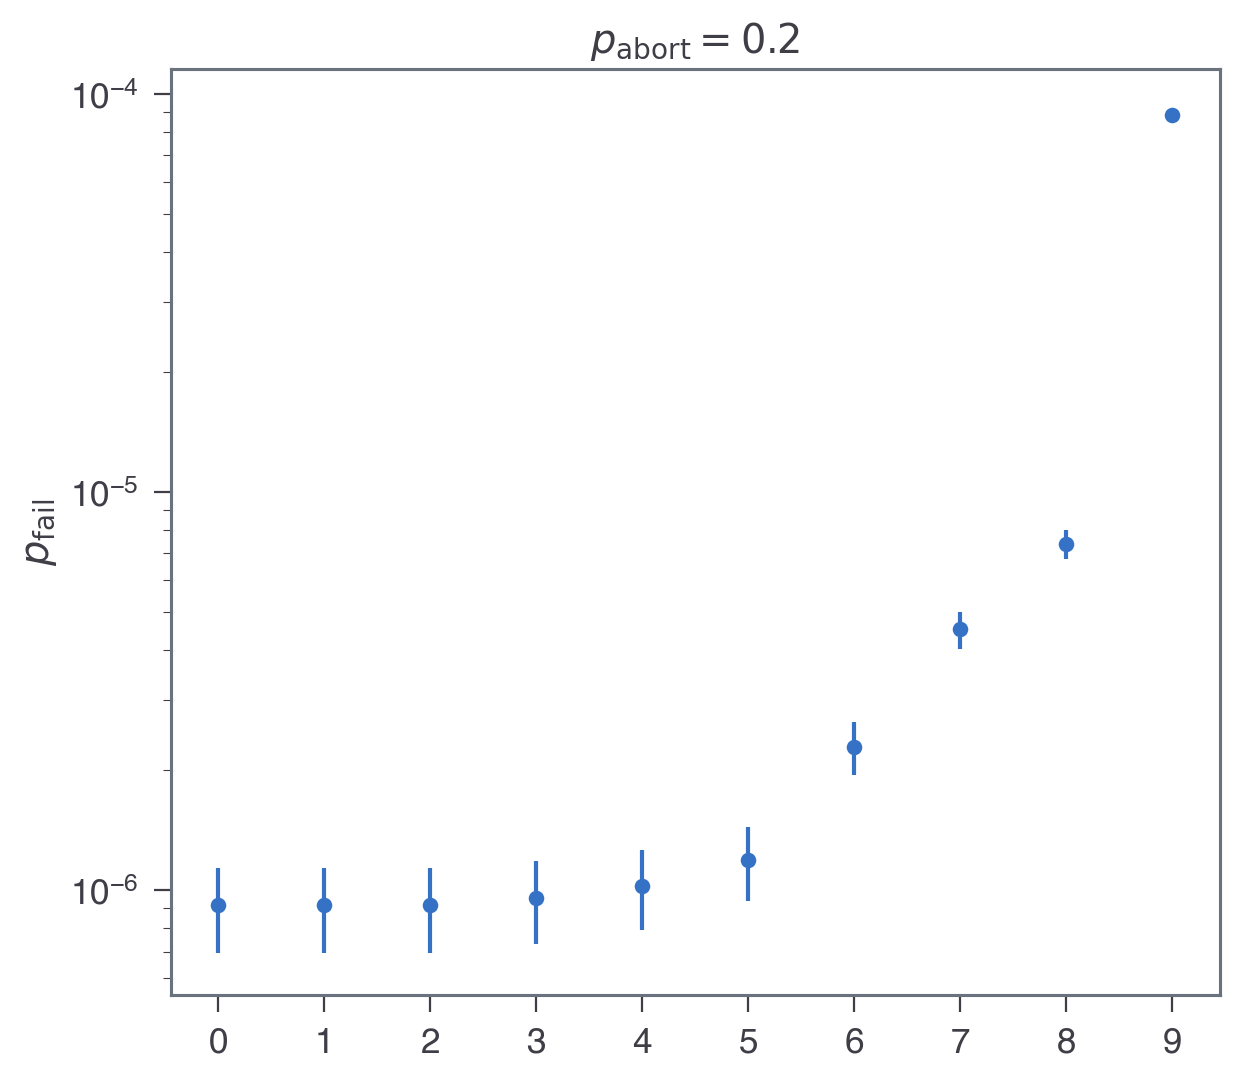

In [11]:
target = 0.2
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()

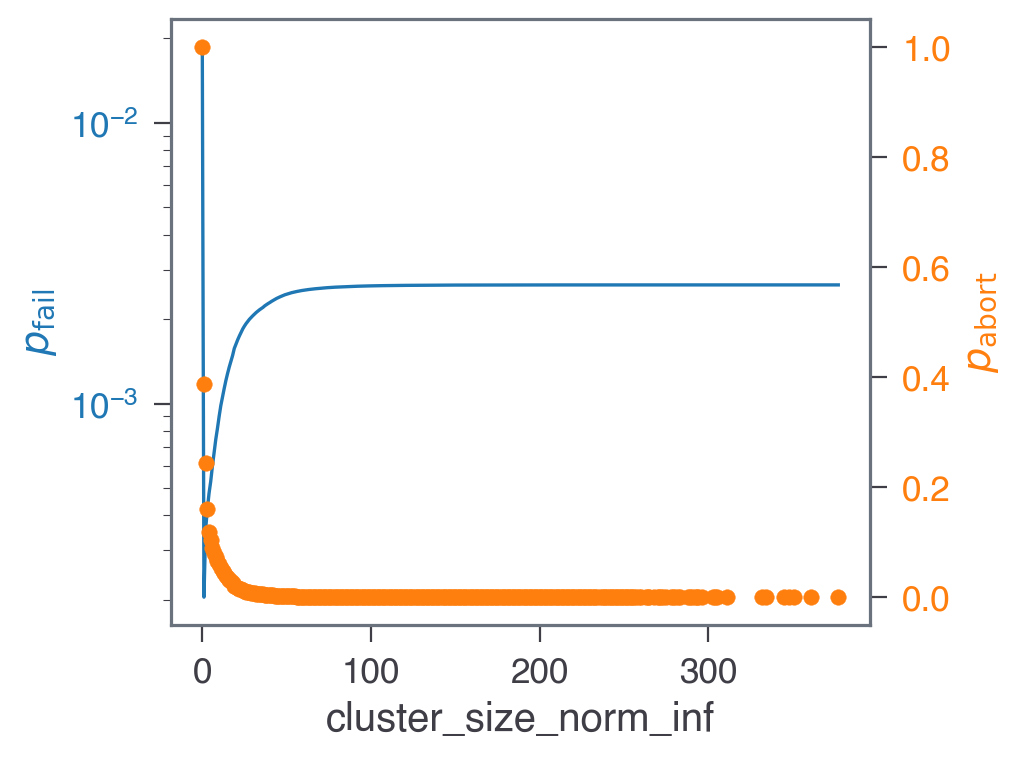

In [108]:
d = T = 9
p = 0.005
by = "cluster_size_norm_inf"

df_ps = df_ps_dict[by].loc[idx[d, T, p, :], :]

x_vals = df_ps.index.get_level_values(3).values
p_fail = df_ps["p_fail"].values
p_abort = df_ps["p_abort"].values

fig, ax1 = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

color1 = COLORS(0)
color2 = COLORS(1)

ax1.plot(x_vals, p_fail, color=color1, label="p_fail")
ax1.set_ylabel(r"$p_\mathrm{fail}$", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xlabel(by)
ax1.set_yscale("log")

ax2 = ax1.twinx()
ax2.scatter(x_vals, p_abort, color=color2, label="p_abort")
ax2.set_ylabel(r"$p_\mathrm{abort}$", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

fig.tight_layout()

0: matching_gap (1.35e-09 ± 7.64e-10)
1: cluster_llr_norm_gap_inf (1.86e-06 ± 2.97e-08)
2: cluster_llr_norm_gap_2 (1.88e-06 ± 2.98e-08)
3: cluster_llr_norm_1 (2.00e-06 ± 3.08e-08)
4: cluster_llr_norm_gap_1 (2.00e-06 ± 3.08e-08)
5: cluster_llr_norm_2 (2.08e-06 ± 3.14e-08)
6: cluster_llr_norm_inf (2.76e-06 ± 3.62e-08)
7: cluster_llr_norm_gap_0.5 (6.60e-06 ± 5.59e-08)
8: pred_llr (6.74e-06 ± 5.65e-08)
9: matching_pred_llr (7.21e-06 ± 5.85e-08)
10: cluster_llr_norm_0.5 (8.15e-06 ± 6.22e-08)
11: matching_detector_density (1.15e-05 ± 7.32e-08)
12: detector_density (1.58e-05 ± 8.57e-08)


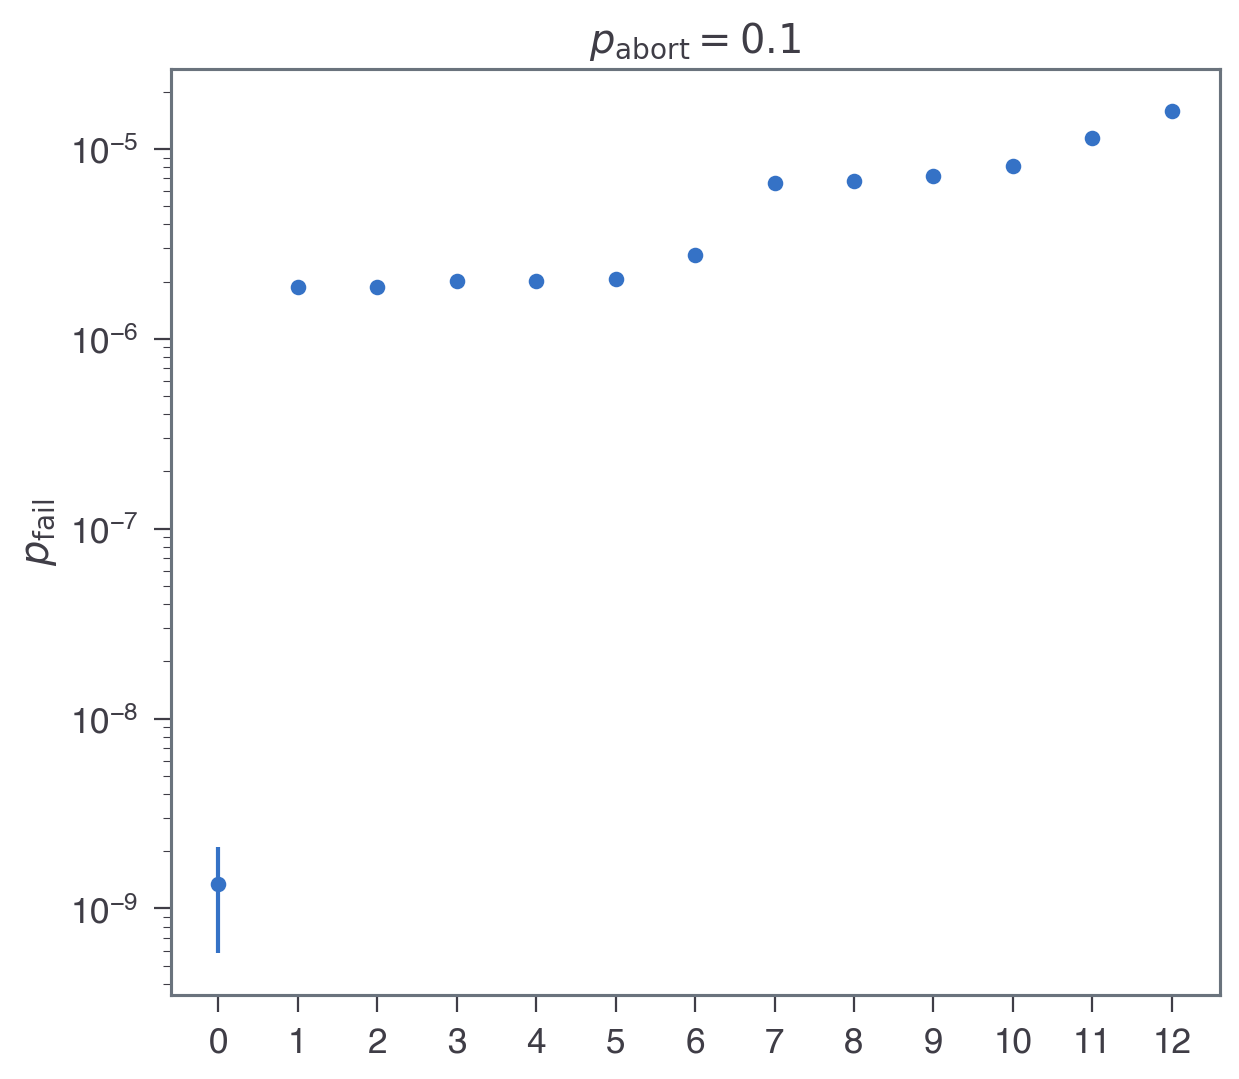

## pfail vs p for a fixed abort rate

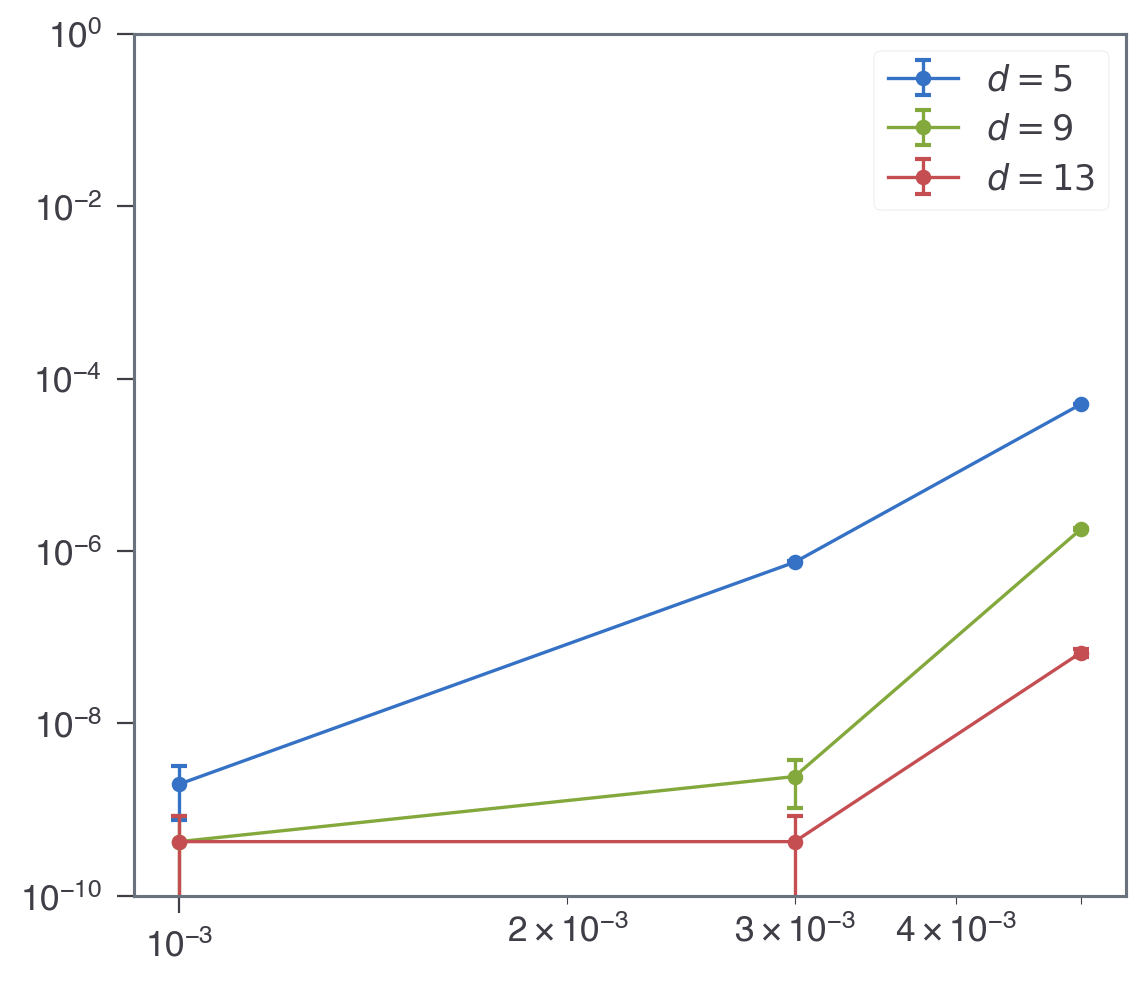

In [101]:
by = "matching_gap"
target_p_abort = 0.1

df_ps = df_ps_dict[by]
dlist = df_ps.index.get_level_values("d").unique()
for i_d, d in enumerate(dlist):
    df_ps_d = df_ps.loc[idx[d, d, :, :], :]
    plist = df_ps_d.index.get_level_values("p").unique()
    pfails = []
    delta_pfails = []
    for i_p, p in enumerate(plist):
        df_ps_dp = df_ps_d.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_dp["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_dp.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_dp.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        plist,
        pfails,
        yerr=delta_pfails,
        label=f"$d={d}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-10, 1)
plt.legend()

## pfail vs d for a fixed abort rate

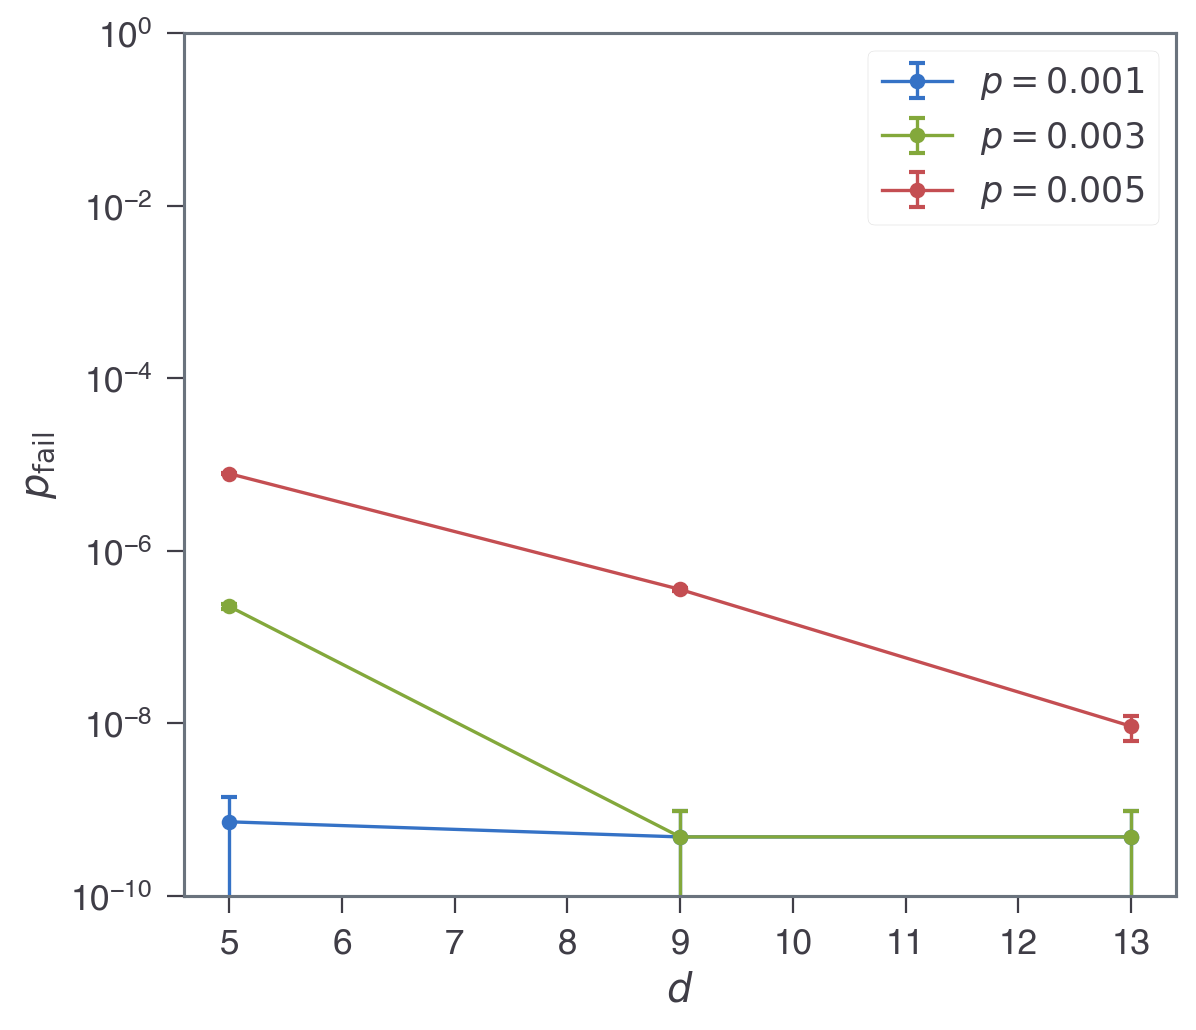

In [104]:
by = "matching_gap"
target_p_abort = 0.2

df_ps = df_ps_dict[by]
plist = df_ps.index.get_level_values("p").unique()
dlist = df_ps.index.get_level_values("d").unique()

for i_p, p in enumerate(plist):
    pfails = []
    delta_pfails = []
    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_d["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_d.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_d.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        dlist,
        pfails,
        yerr=delta_pfails,
        label=f"$p={p}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.ylim(1e-10, 1)
plt.xlabel("$d$")
plt.ylabel("$p_{\\mathrm{fail}}$")
plt.legend()